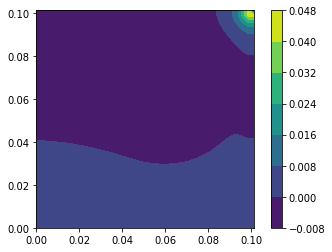

In [1]:
# this read a fortran binary file (fields_****.fw) in ./cavity  
import matplotlib.pyplot as plt
import numpy as np
# --------------------------------------------- #
icase=1
if icase==1:
    dir='../run/pool/'
    filename=dir+'fields_' 
    # compiled by 
    # $gfortran -fconvert=big-endian main.f90 
    # ----------------- #
    # 4byte_recl+'u'+4byte_recl
    # 4byte_recl+'v'+4byte_recl
    # 4byte_recl+'p'+4byte_recl
    # ----------------- #
    Lx=0.1; Ly=Lx; Uwall=0.1;
    Nx=41; Ny=43
    iff=30; ill=30
    iskip=2
    
dx=Lx/np.float(Nx-1)
dy=Ly/np.float(Ny-1)

x=np.array(np.zeros(Nx+2),dtype=np.float64)
xc=np.array(np.zeros(Nx+1),dtype=np.float64)
x[0]=0.0
for i in range(1,Nx+1):
    x[i]=x[i-1]+dx
    xc[i]=0.5*(x[i-1]+x[i])
    
y=np.array(np.zeros(Ny+2),dtype=np.float64)
yc=np.array(np.zeros(Ny+1),dtype=np.float64)
y[0]=0.0
for i in range(1,Ny+1):
    y[i]=y[i-1]+dy
    yc[i]=0.5*(y[i-1]+y[i])

    
for ifield in range(iff,ill+1):
    
    file_fw=open(filename+'%04d'%ifield+'.fwd')
    head = ("head",">i")
    tail = ("tail",">i")
    byte_u='>'+'%d'%((Nx+2)*(Ny+1))+'d'
    byte_v='>'+'%d'%((Nx+1)*(Ny+2))+'d'
    byte_p='>'+'%d'%((Nx+1)*(Ny+1))+'d'
    fld_u = np.dtype([head, ("u",byte_u), tail])
    fld_v = np.dtype([head, ("v",byte_v), tail])
    fld_p = np.dtype([head, ("p",byte_p), tail])
    tmp = np.fromfile(file_fw, dtype=fld_u, count=1) # u
    u=tmp[0]["u"].reshape(Ny+1,Nx+2)
    uc=0.5*(u[:,:-1]+u[:,1:]) # interpolate at the cell centre
    
    tmp = np.fromfile(file_fw, dtype=fld_v, count=1) # v
    v=tmp[0]["v"].reshape(Ny+2,Nx+1)
    vc=0.5*(v[:-1,:]+v[1:,:]) # interpolate at the cell centre
    
    tmp = np.fromfile(file_fw, dtype=fld_p, count=1) # p
    #p=tmp[0]["p"].reshape(Nx+1,Ny+1,order='F') # reading in fortran order with transposing
    p=tmp[0]["p"].reshape(Ny+1,Nx+1) 
    file_fw.close()

    fig_p, ax_p = plt.subplots()
    tcf=ax_p.contourf(xc,yc,p)
    ax_p.set_aspect('equal')
    fig_p.colorbar(tcf)
    #ax_p.contour(xc,yc,p, colors='k')
    plt.show()
